# Processing Customers
- Aditya Anand

In [62]:
import random
import pandas as pd
import matplotlib.pyplot as plt

simLength = 360000 #100 hrs
random.seed(31415926)
customerPattern = []
for x in range(0,simLength,60):
    if random.random() < 0.9:
        box = "small"
    else:
        box = "large"
    customerPattern.append(box)

### Monte Carlo simulation function
- Inputs the policy that the cashier uses
- Inputs the max time taken
- Inputs a customer pattern that remains consistent throughout different simulations
- Outputs the list of the customers processed in this timeframe

In [63]:

def sim (policy, maxTime, pattern):
    random.seed(31415926)
    waitingList = []
    finishedList = []
    processingEnd = 0
    for t in range(0, maxTime, 30):
        #update waiting times
        for c in waitingList:
            c["waitTime"] += 30
        #start new processing if applicable
        if t >= processingEnd and len(waitingList) > 0:
            i = policy(waitingList)
            c = waitingList[i]
            del waitingList[i]
            finishedList.append(c)
            if c["box"] == "small":
                processingEnd = t + 30
            else:
                processingEnd = t + 5 * 60
        #add customer if applicable
        if t%60 == 0:
            # if random.random() < 0.9:
            #     box = "small"
            # else:
            #     box = "large"
            box = pattern[t//60]
            waitingList.append({"waitTime": 0, "box" : box})
    return finishedList

### Statistics:
- fairness - minimising the difference between the small and large boxes' average wait time; minimising the standard deviation of the time
- efficiency - maximising the number of customers processed per minute -- upper bound is 2

In [64]:
def stats(results):
    df = pd.DataFrame(results)
    df.waitTime.mean()
    print(f"Small boxes: {len(df[df.box == 'small'])}; avg time: {round(df[df.box=='small'].waitTime.mean() * 1000)/1000}")
    print(f"Large boxes: {len(df[df.box == 'large'])}; avg time: {round(df[df.box=='large'].waitTime.mean() * 1000)/1000}")
    print(f"Std deviation:{round(df.waitTime.std() * 1000)/1000}; customers per minute: {round(len(df)/(simLength/60) * 1000)/1000}")

### Baseline: first come first serve policy
- Always choose the first customer

In [65]:
def firstComeFirstServe(waitingList):
    return 0
results = sim(firstComeFirstServe, simLength, customerPattern)
stats(results)

Small boxes: 5394; avg time: 1472.914
Large boxes: 594; avg time: 1534.596
Std deviation:1572.067; customers per minute: 0.998


### Alternating baskets
- Start with a small basket, and then go to a large basket, and then small again

In [66]:
doSmall = True
def alternatingBaskets(waitingList):
    global doSmall
    for x in range(0, len(waitingList)):
        if doSmall and waitingList[x]["box"] == "small":
            doSmall = not doSmall
            return x
        if not doSmall and waitingList[x]["box"] == "large":
            doSmall = not doSmall
            return x
    return 0
results = sim(alternatingBaskets, simLength, customerPattern)
stats(results)

Small boxes: 5391; avg time: 2954.825
Large boxes: 595; avg time: 189.731
Std deviation:3379.774; customers per minute: 0.998


### Periodic Alteration
- Similar idea as altering baskets, except the choices are altered in groups rather than alone.

In [67]:
doSmall = True
alterTime = 1
alterPeriod = 1
def periodicAlteration(waitingList):
    global doSmall, alterTime, alterPeriod
    for x in range(0, len(waitingList)):
        if doSmall and waitingList[x]["box"] == "small":
            alterPeriod += 1
            if alterPeriod == alterTime:
                doSmall = not doSmall
            return x
        if not doSmall and waitingList[x]["box"] == "large":
            alterPeriod += 1
            if alterPeriod == alterTime:
                doSmall = not doSmall
            return x
    return 0
results = sim(periodicAlteration, simLength, customerPattern)
stats(results)

Small boxes: 5404; avg time: 148.64
Large boxes: 593; avg time: 2740.675
Std deviation:1187.9; customers per minute: 1.0


### Optimising the alterPeriod

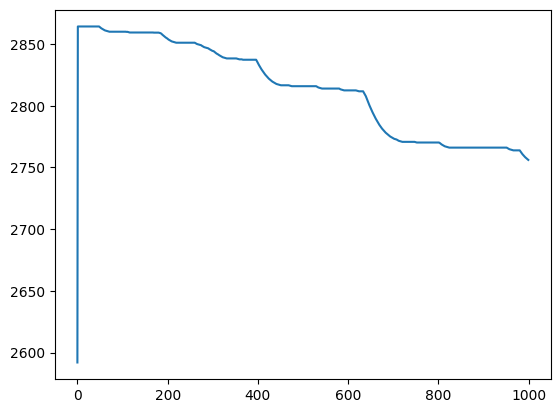

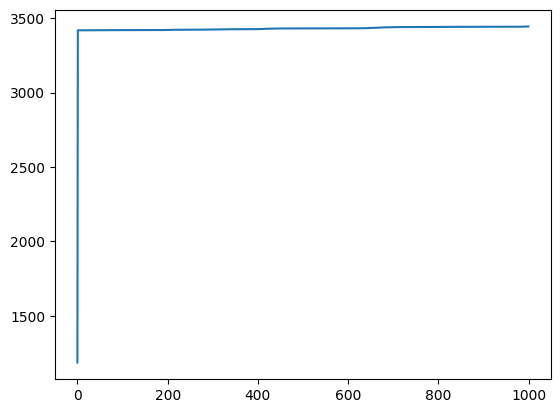

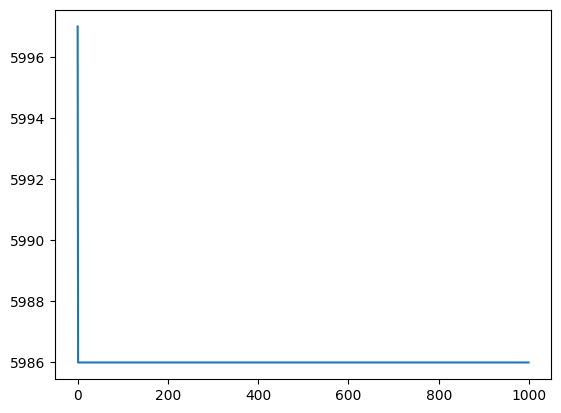

In [68]:
xpoints = []
ff1points = []
ff2points = []
efficiencypoints = []
for x in range(0,1000):
    doSmall = True
    alterTime = x
    alterPeriod = 0
    results = sim(periodicAlteration, simLength, customerPattern)
    df = pd.DataFrame(results)
    df.waitTime.mean()
    fairFactor1 = abs(df[df.box == 'small'].mean(numeric_only=True) - df[df.box == 'large'].mean(numeric_only=True))
    fairFactor2 = df.std(numeric_only=True)
    xpoints.append(x)
    ff1points.append(fairFactor1)
    ff2points.append(fairFactor2)
    efficiencypoints.append(len(df))

plt.plot(xpoints, ff1points)
plt.show()
plt.plot(xpoints, ff2points)
plt.show()
plt.plot(xpoints, efficiencypoints)
plt.show()

### Minimising Queues

- If there are more people with large baskets than small baskets, then take people with large baskets. Otherwise, take people with small baskets

In [69]:
def minimisingQueues(waitingList):
    df = pd.DataFrame(waitingList)
    smallLength = len(df[df.box == 'small'])
    largeLength = len(df[df.box == 'large'])
    for x in range(0, len(waitingList)):
        if waitingList[x]["box"] == "small" and smallLength > largeLength:
            return x
        elif waitingList[x]["box"] == "large" and smallLength <= largeLength:
            return x
results = sim(minimisingQueues, simLength, customerPattern)
stats(results)

Small boxes: 5402; avg time: 444.913
Large boxes: 594; avg time: 2468.333
Std deviation:1073.655; customers per minute: 0.999


### Fully Random

- Randomly choose which one you want to process

In [70]:
def fullyRandom(waitingList):
    return random.randint(0,len(waitingList)-1)
results = sim(fullyRandom, simLength, customerPattern)
stats(results)

Small boxes: 5394; avg time: 1501.424
Large boxes: 594; avg time: 1508.434
Std deviation:2699.504; customers per minute: 0.998


### Randomized by ratio

In [71]:
randomRatio = 1
def randomByRatio(waitingList):
    global randomRatio
    df = pd.DataFrame(waitingList)
    smallLength = len(df[df.box == 'small'])
    largeLength = len(df[df.box == 'large'])
    probability = (randomRatio * smallLength) / (smallLength + largeLength)
    if random.random() < randomRatio:
        for x in range(0, len(waitingList)):
            if waitingList[x]["box"] == "small":
                return x
    else:
        for x in range(0, len(waitingList)):
            if waitingList[x]["box"] == "large":
                return x
    return 0
results = sim(randomByRatio, simLength, customerPattern)
stats(results)

Small boxes: 5404; avg time: 148.64
Large boxes: 593; avg time: 2740.675
Std deviation:1187.9; customers per minute: 1.0


### Optimising the randomRatio

Here, I try to optimise the randomRatio component of my previous strategy

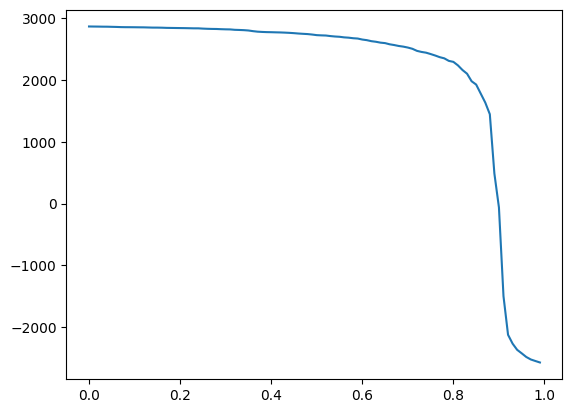

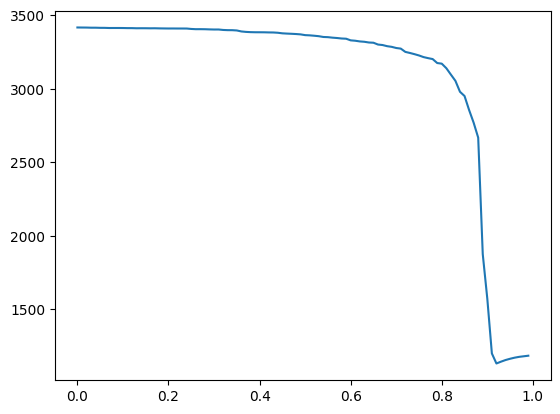

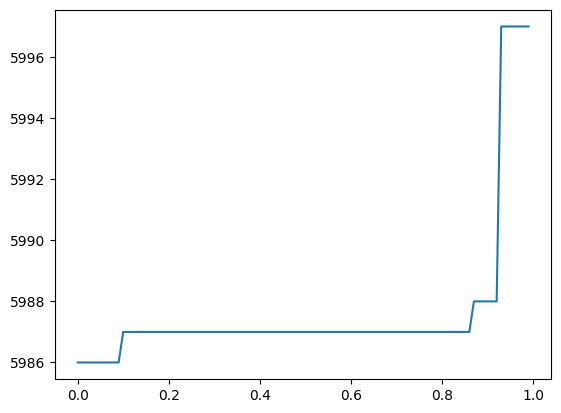

In [72]:
xpoints = []
ff1points = []
ff2points = []
efficiencypoints = []
for x in range(0,100):
    randomRatio = x / 100
    results = sim(randomByRatio, simLength, customerPattern)
    df = pd.DataFrame(results)
    df.waitTime.mean()
    fairFactor1 = df[df.box == 'small'].mean(numeric_only=True) - df[df.box == 'large'].mean(numeric_only=True)
    fairFactor2 = df.std(numeric_only=True)
    xpoints.append(x/100)
    ff1points.append(fairFactor1)
    ff2points.append(fairFactor2)
    efficiencypoints.append(len(df))

plt.plot(xpoints, ff1points)
plt.show()
plt.plot(xpoints, ff2points)
plt.show()
plt.plot(xpoints, efficiencypoints)
plt.show()

### Choosing the best one

- Comparing all strategies using all 3 criteria using percentiles
- Averaging all 3 percentiles to form one that is used

In [73]:
xpoints = []
ff1points = []
ff2points = []
efficiencypoints = []
def addData(name, strategy):
    results = sim(strategy, simLength, customerPattern)
    df = pd.DataFrame(results)
    fairFactor1 = abs(df[df.box == 'small'].mean(numeric_only=True) - df[df.box == 'large'].mean(numeric_only=True))
    fairFactor2 = df.std(numeric_only=True)
    fairFactor1 = int(fairFactor1)
    fairFactor2 = int(fairFactor2)
    xpoints.append(name)
    ff1points.append(fairFactor1)
    ff2points.append(fairFactor2)
    efficiencypoints.append(len(df) - 5975)

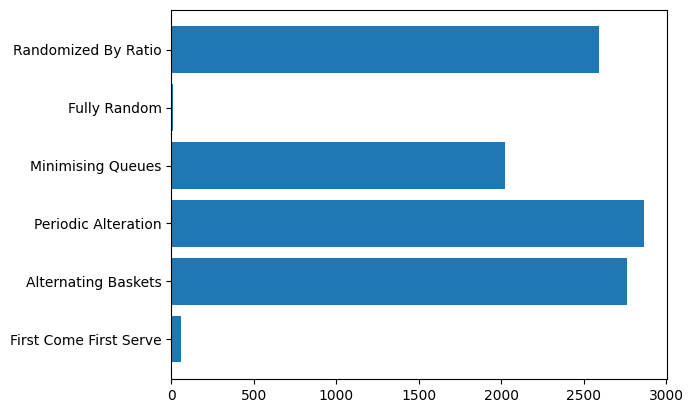

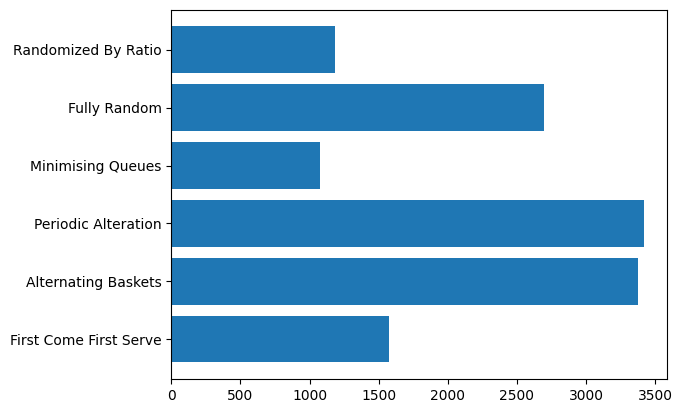

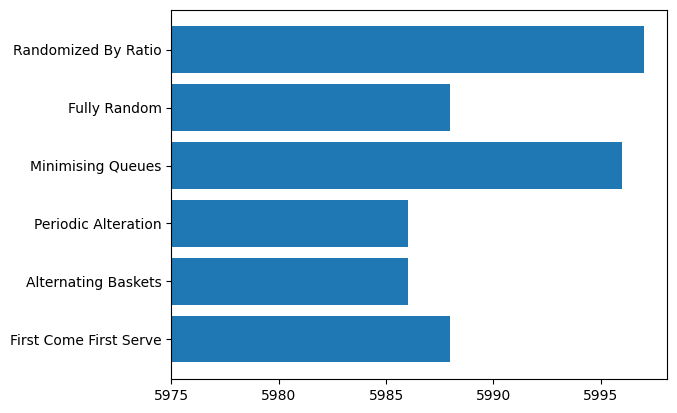

In [74]:
addData("First Come First Serve", firstComeFirstServe)
addData("Alternating Baskets", alternatingBaskets)
doSmall = True
alterTime = 1
alterPeriod = 0
addData("Periodic Alteration", periodicAlteration)
addData("Minimising Queues", minimisingQueues)
addData("Fully Random", fullyRandom)
randomRatio = 1
addData("Randomized By Ratio", randomByRatio)
# Create the bar chart
plt.barh(xpoints, ff1points)
plt.show()
plt.barh(xpoints, ff2points)
plt.show()
plt.barh(xpoints, efficiencypoints, 0.8, 5975)
plt.show()

# Find the best strategy
totals = [0,0,0]
for x in range(0,len(xpoints)):
    totals[0] += ff1points[x]
    totals[1] += ff2points[x]
    totals[2] += efficiencypoints[x]


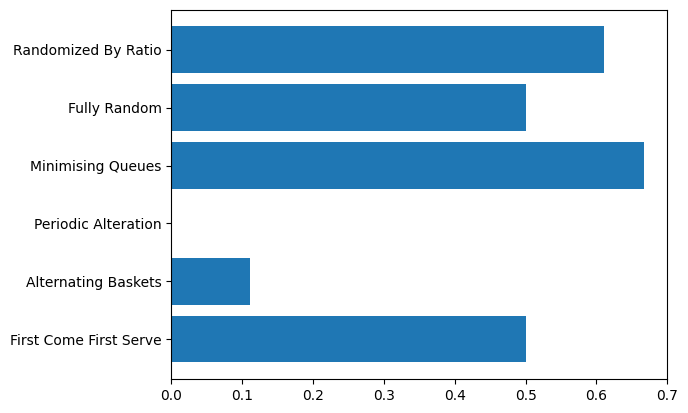

In [75]:
# Finding the best strategy
totalPoints = []
for x in range(0, len(xpoints)):
    percentileff1 = 0
    percentileff2 = 0
    percentileeff = 0
    for y in range(0, len(xpoints)):
        if ff1points[x] < ff1points[y]:
            percentileff1 += 1
        if ff2points[x] < ff2points[y]:
            percentileff2 += 1
        if efficiencypoints[x] > efficiencypoints[y]:
            percentileeff += 1
    percentileff1 /= len(xpoints)
    percentileff2 /= len(xpoints)
    percentileeff /= len(xpoints)
    totalPoints.append((percentileff1 + percentileff2 + percentileeff)/3)
plt.barh(xpoints, totalPoints)
plt.show()

# 

### Changing my method to choose the best strategy

- I realized that my current method disproportionately values fairness over efficiency, so I used a 25 - 25 - 50 weigth with fairness - fairness - efficiencyto make up for this

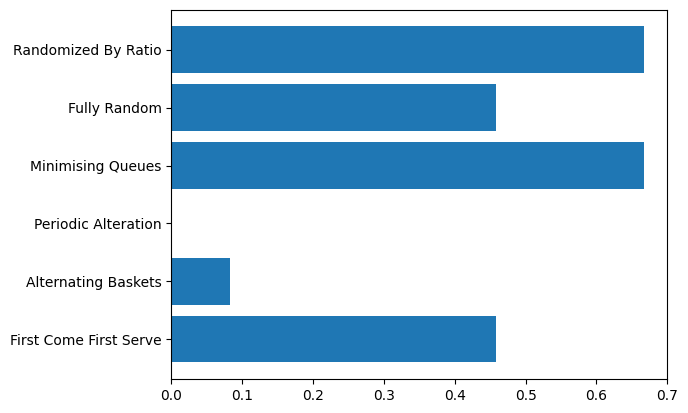

In [76]:
totalPoints = []
for x in range(0, len(xpoints)):
    percentileff1 = 0
    percentileff2 = 0
    percentileeff = 0
    for y in range(0, len(xpoints)):
        if ff1points[x] < ff1points[y]:
            percentileff1 += 1
        if ff2points[x] < ff2points[y]:
            percentileff2 += 1
        if efficiencypoints[x] > efficiencypoints[y]:
            percentileeff += 1
    percentileff1 /= len(xpoints)
    percentileff2 /= len(xpoints)
    percentileeff /= len(xpoints)
    totalPoints.append((0.25 * percentileff1 + 0.25 * percentileff2 + 0.5 * percentileeff))
plt.barh(xpoints, totalPoints)
plt.show()

## WINNER: Minimising Queues!!!